# Titanic Dataset: Family Size Impact on Survival and Fare

This analysis explores how **family size** affected passenger **survival rate** and **fare paid** aboard the Titanic.

We:
- Load and inspect Titanic data
- Engineer a `FamilySize` feature
- Classify passengers into family size categories: Solo, Small, Medium, Large
- Analyze average **fare** and **survival rate** by class and family size


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyhere import here
import os


## Step 1: Load and Inspect Dataset

We use `pyhere` to load the data in a reproducible, cross-platform safe way. Below, we inspect the dataset for shape, missing values, and column types.


In [6]:
file_path = here(r"titanic_train.csv")
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found: {file_path}")

titanic_df = pd.read_csv(file_path)


In [8]:
titanic_df.head()
titanic_df.info()
titanic_df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Column | Missing | Handling Approach

Age | 177 | Fill with median (or predictive imputation)

Cabin | 687 | Drop column (too sparse to be useful)

Embarked | 2 | Fill with mode (most common embarkation point)

In [11]:
# Drop highly sparse column
titanic_df.drop(columns=["Cabin"], inplace=True)

# Fill missing Age with median
titanic_df["Age"].fillna(titanic_df["Age"].median(), inplace=True)

# Fill missing Embarked with mode
titanic_df["Embarked"].fillna(titanic_df["Embarked"].mode()[0], inplace=True)

# Confirm no missing values left in critical columns
print(titanic_df[["Age", "Fare", "Embarked"]].isna().sum())

Age         0
Fare        0
Embarked    0
dtype: int64


C:\Users\ASUS\AppData\Local\Temp\ipykernel_6156\3541562834.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_df["Age"].fillna(titanic_df["Age"].median(), inplace=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_6156\3541562834.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a 

## Step 2: Family Size Features

We compute a new column `FamilySize` using:

**Formula:** FamilySize = SibSp + Parch + 1

(SibSp: Siblings/Spouses aboard, Parch: Parents/Children aboard)

We then categorize passengers based on size:

Solo (1)

Small (2–4)

Medium (5–7)

Large (8–11)

In [15]:
# Define family categories
fam_cat = {
    "Solo": [1, 1],
    "Small": [2, 4],
    "Medium": [5, 7],
    "Large": [8, 11]
}

# Classification function
def assign_family_category(family_size):
    for category, (lower, upper) in fam_cat.items():
        if lower <= family_size <= upper:
            return category
    return "Unknown"

# Compute family size
titanic_df["FamilySize"] = titanic_df["SibSp"] + titanic_df["Parch"] + 1
titanic_df["FamilyCategory"] = titanic_df["FamilySize"].apply(assign_family_category)

## Step 3: Save Cleaned Data

We save the processed dataset for further reuse.

In [18]:
output_file = here("titanic_df_with_family_size.csv")
titanic_df.to_csv(output_file, index=False)
print(f"Saved to: {output_file}")

Saved to: C:\Users\ASUS\titanic_df_with_family_size.csv


## Step 4: Analyze Survival Rate and Fare by Group

Now we compute a **pivot table** grouped by:
- Passenger class (`Pclass`)
- Family category (`FamilyCategory`)

The table shows average:
- Survival rate
- Fare paid

**Pivot Table Analysis**

In [22]:
pivot_table = titanic_df.pivot_table(index=["Pclass", "FamilyCategory"],
                                     values=["Survived", "Fare"],
                                     aggfunc={"Survived": "mean", "Fare": "mean"},
                                     fill_value=0,
                                     margins=True).reset_index()

pivot_table.columns = ["Pclass", "FamilyCategory", "Average_Survival_Rate", "Average_Fare"]
pivot_table

,Pclass,FamilyCategory,Average_Survival_Rate,Average_Fare
0,1,Medium,262.791667,0.666667
1,1,Small,95.647114,0.732673
2,1,Solo,63.672514,0.532110
3,2,Medium,20.875000,1.000000
4,2,Small,29.451496,0.628205
5,2,Solo,14.066106,0.346154
6,3,Large,59.096154,0.000000
7,3,Medium,29.932117,0.097561
8,3,Small,15.177730,0.407080
9,3,Solo,9.272052,0.212963


## Step 5: Visualize the Results

Bar plot: Survival rate by Family Category and Pclass.

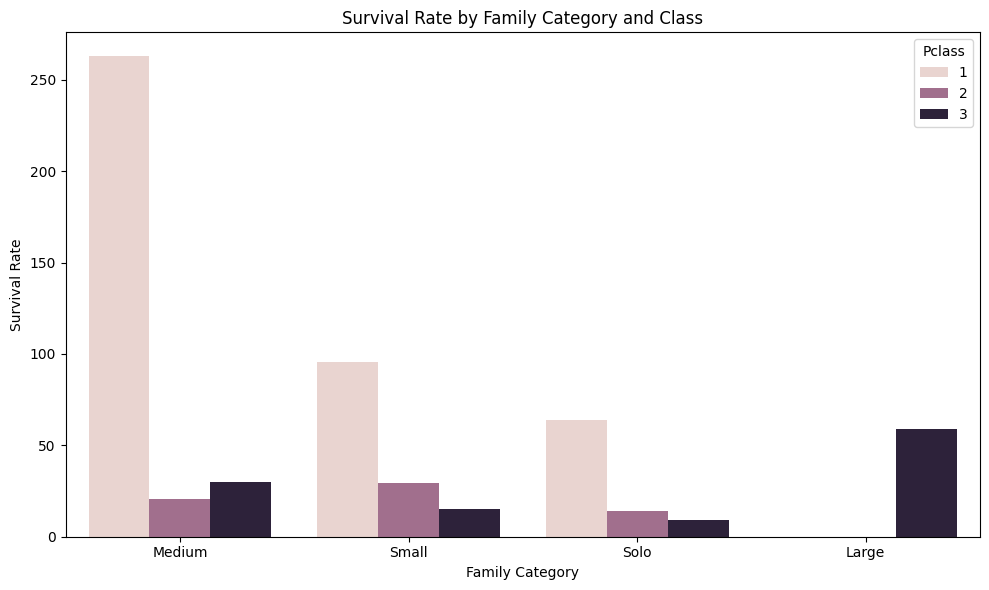

In [25]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.barplot(data=pivot_table[pivot_table["Pclass"] != "All"],
            x="FamilyCategory", y="Average_Survival_Rate", hue="Pclass")
plt.title("Survival Rate by Family Category and Class")
plt.ylabel("Survival Rate")
plt.xlabel("Family Category")
plt.tight_layout()
plt.show()